<a href="https://colab.research.google.com/github/franticalien/ViSION-Stuff/blob/main/fasterRCNN_Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/FasterRCNN/Dataset'

/content/drive/MyDrive/FasterRCNN/Dataset


In [ ]:
import shutil
imgs = []
classes = ['car', 'person', 'traffic light']
for img in os.listdir(os.path.join(dir,'images')):
            ann_path = os.path.join(dir, 'annotations', img.replace('png','xml'))
            objects = et.parse(ann_path).getroot().findall('object')
            if any([obj.find('name').text in classes for obj in objects]):
               imgs.append(img)

In [ ]:
print(len(imgs))

In [6]:
lst = os.listdir('/content/drive/MyDrive/FasterRCNN/Dataset/images_subset/')
print(len(lst))

7063


In [5]:
# Setting up the Dataset Class :

import cv2
import os
import torch
import numpy as np
from xml.etree import ElementTree as et
from torch.utils.data import  Dataset

dir = '/content/drive/MyDrive/FasterRCNN/Dataset'

class TrafficDataset(Dataset):

    def __init__(self, dir, width, height, transforms=None):
        super().__init__()
        self.dir = dir
        self.width = width
        self.height = height
        self.transforms = transforms
        self.classes = [_, 'car', 'person', 'traffic light']
        self.images = [img for img in os.listdir(os.path.join(dir,'images_subset'))][:1000]
            
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir, 'images', self.images[idx])
        img = cv2.imread(img_path)
        ht, wd = img.shape[0], img.shape[1]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255

        ann_path = os.path.join(self.dir, 'annotations', self.images[idx].replace('png','xml'))

        boxes, labels = [], []
        tree = et.parse(ann_path)
        root = tree.getroot()
        
        for obj in root.findall('object'):
           if obj.find('name').text in self.classes:
            bb = obj.find('bndbox')
            xmin = int(bb.find('xmin').text) 
            xmax = int(bb.find('xmax').text)
            ymin = int(bb.find('ymin').text)
            ymax = int(bb.find('ymax').text)
            xmin, xmax = (xmin/wd)*self.width, (xmax/wd)*self.width
            ymin, ymax = (ymin/ht)*self.height, (ymax/ht)*self.height
            boxes.append([xmin, ymin, xmax+0.0001, ymax+0.0001])
            labels.append(self.classes.index(obj.find('name').text))

        boxes = torch.as_tensor(boxes, dtype=torch.float64)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0]), dtype=torch.int64)
        area = (boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1])

        target = {'boxes' : boxes,
                  'labels' : labels,
                  'area' : area,
                  'iscrowd' : iscrowd,
                  'image_id' : torch.tensor([idx])
                  }

        if self.transforms:
            sample = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        
        return img, target  

In [7]:
# Plotting Images with Bounding Boxes :

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image(img, target):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    ax.imshow(img)
    
    for bb in target['boxes']:
        x,y,w,h = bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]
        rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='y', facecolor='none')
        ax.add_patch(rect)
    plt.show()

Total Images in Dataset = 1000
Number of Classes = 3
Classes = ['car', 'person', 'traffic light']


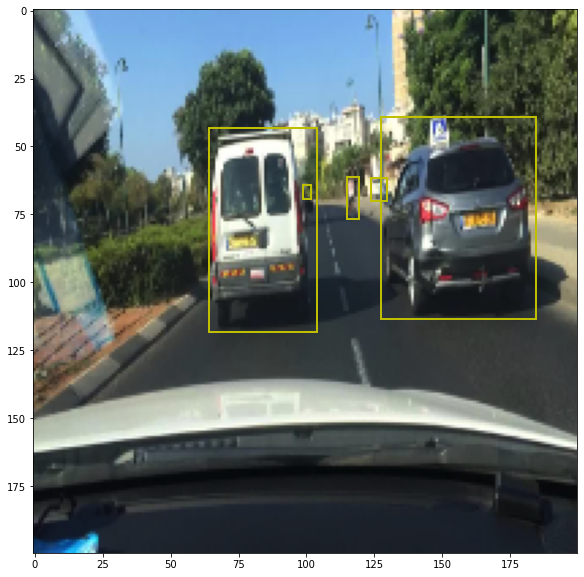

In [8]:
# Plotting an example : 

dataset = TrafficDataset(dir, 200, 200)
print(f"Total Images in Dataset = {len(dataset)}")
print(f"Number of Classes = {len(dataset.classes)-1}")
print(f"Classes = {dataset.classes[1:]}")
img, target = dataset[237]
plot_image(img, target)

In [9]:
!pip install -q -U albumentations

     |████████████████████████████████| 98 kB 3.4 MB/s 
     |████████████████████████████████| 37.1 MB 48 kB/s 


In [10]:
# Defining Transforms : 

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transform():
    return A.Compose([A.HorizontalFlip(0.5), ToTensorV2(p=1.0)],
                      bbox_params = {'format':'pascal_voc', 'label_fields':['labels']})
def get_test_transform():
    return A.Compose([ToTensorV2(p=1.0)], bbox_params = {'format':'pascal_voc', 'label_fields':['labels']})

In [11]:
!pip install utils

In [12]:
# Loading and Splitting the Dataset :

import utils
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

width, height = 200, 200
test_split = 0.05

train_dataset = TrafficDataset(dir, width, height, transforms=get_train_transform())
test_dataset = TrafficDataset(dir, width, height, transforms=get_test_transform())

num_classes = len(train_dataset.classes)

indices = torch.randperm(len(train_dataset)).tolist()
test_size = int(len(train_dataset)*test_split)

train_dataset = torch.utils.data.Subset(train_dataset, indices[:-test_size])
test_dataset = torch.utils.data.Subset(test_dataset, indices[-test_size:])

train_dataloader =  DataLoader(train_dataset, batch_size=10, shuffle=True,
                               num_workers=2, collate_fn=collate_fn)
test_dataloader =  DataLoader(test_dataset, batch_size=10, shuffle=False,
                               num_workers=2, collate_fn=collate_fn)

In [13]:
# Defining the Model :

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
# Initializing Model

model = get_model(num_classes)
model.to(device)

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(parameters, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [16]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=48e66e666b115cf9743bff7a2c9ba4e427962515bd1d0ff2e5931eb868dd7094
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 11.7 GB  |     Proc size: 2.1 GB
GPU RAM Free: 10825MB | Used: 616MB | Util   5% | Total     11441MB


In [17]:
# Training

from engine import train_one_epoch, evaluate

epochs = 6

for i in range(epochs):
    train_one_epoch(model, optimizer, train_dataloader, device, i, print_freq=10)
    lr_scheduler.step()
    evaluate(model, test_dataloader, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/95]  eta: 0:26:51  lr: 0.000058  loss: 2.8321 (2.8321)  loss_classifier: 1.4768 (1.4768)  loss_box_reg: 0.7011 (0.7011)  loss_objectness: 0.4093 (0.4093)  loss_rpn_box_reg: 0.2449 (0.2449)  time: 16.9637  data: 12.4707  max mem: 8184
Epoch: [0]  [10/95]  eta: 0:09:58  lr: 0.000590  loss: 2.5024 (2.4882)  loss_classifier: 1.2154 (1.1398)  loss_box_reg: 0.7675 (0.7504)  loss_objectness: 0.2839 (0.3271)  loss_rpn_box_reg: 0.2714 (0.2708)  time: 7.0434  data: 2.9905  max mem: 8514
Epoch: [0]  [20/95]  eta: 0:07:41  lr: 0.001121  loss: 1.8604 (2.1044)  loss_classifier: 0.6869 (0.8751)  loss_box_reg: 0.7147 (0.6890)  loss_objectness: 0.2192 (0.2804)  loss_rpn_box_reg: 0.2440 (0.2599)  time: 5.6128  data: 1.6081  max mem: 8514
Epoch: [0]  [30/95]  eta: 0:06:34  lr: 0.001652  loss: 1.5340 (1.8764)  loss_classifier: 0.4596 (0.7201)  loss_box_reg: 0.5781 (0.6547)  loss_objectness: 0.1619 (0.2359)  loss_rpn_box_reg: 0.2426 (0.2657)  time: 5.5289  data: 1.5247  max mem: 8514
Epoch:

In [19]:
def pil(image):
    return torchvision.transforms.ToPILImage()(image).convert('RGB')

predicted boxes:  100
expected boxes:  34


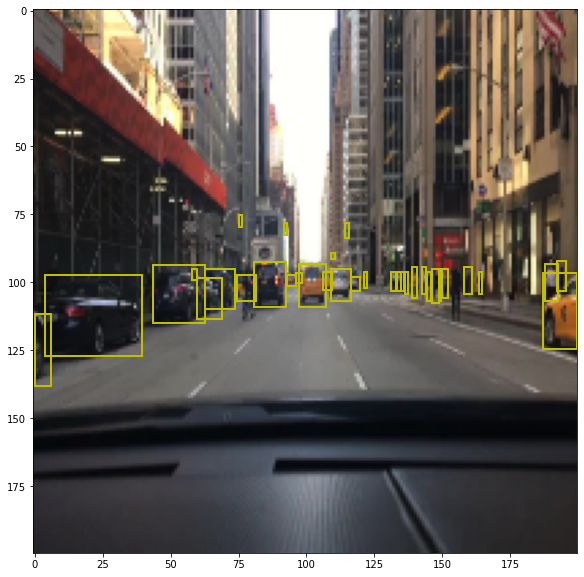

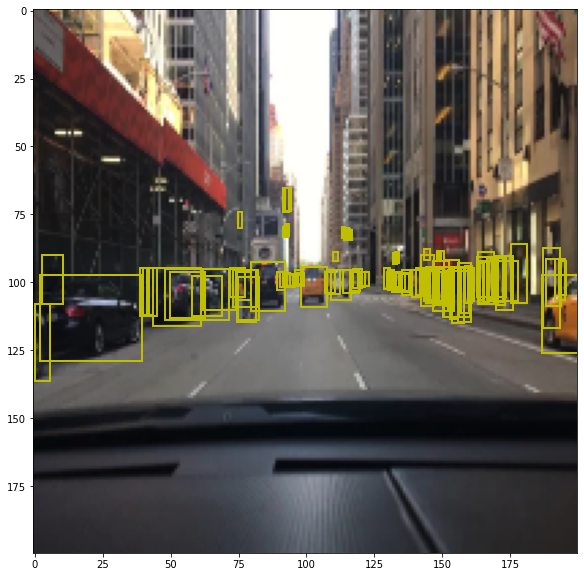

In [79]:
import torchvision

img, target = test_dataset[19]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
print('predicted boxes: ', len(prediction['labels']))
print('expected boxes: ', len(target['labels']))

plot_image(pil(img), target)
plot_image(pil(img), prediction)

In [39]:
def nms(prediction, iou_threshold=0.1):
    bb = torchvision.ops.nms(prediction['boxes'], prediction['scores'], iou_threshold)
    prediction['boxes'] = prediction['boxes'][bb]
    prediction['scores'] = prediction['scores'][bb]
    prediction['labels'] = prediction['labels'][bb]

    return prediction

predicted boxes:  32


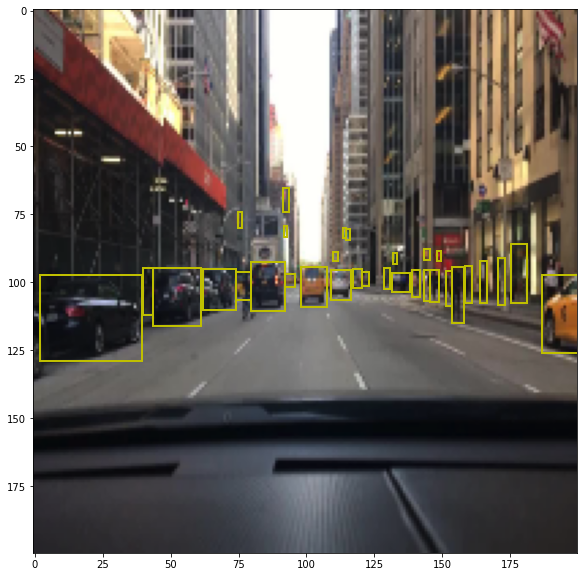

In [80]:
nms_prediction = nms(prediction, iou_threshold=0.01)
print('predicted boxes: ', len(prediction['labels']))
plot_image(pil(img), nms_prediction)